In [1]:
import pandas as pd
import numpy as np
import os
import re
import ast
import nltk
import spacy
from tqdm import tqdm
from collections import defaultdict
from nltk.tokenize import word_tokenize
from sklearn.metrics import pairwise_distances
from sentence_transformers import SentenceTransformer, util

# Download the necessary resource for tokenization
nltk.download('punkt')
nltk.download('punkt_tab')  # Download the missing resource

# Load Models
embedding_model = SentenceTransformer('all-MiniLM-L6-v2', device='cpu')
nlp = spacy.load("en_core_web_sm")

# Bias-related keyword sets (EN)
bias_keywords = {
    'gender': [
        'he', 'she', 'him', 'her', 'his', 'hers', 'man', 'woman', 'men', 'women',
        'boy', 'girl', 'father', 'mother', 'son', 'daughter', 'husband', 'wife',
        'housewife', 'businessman', 'businesswoman', 'nurse', 'doctor', 'engineer',
        'secretary', 'maid', 'boss', 'career woman', 'female scientist', 'male nurse'
    ],
    'religion': [
        'allah', 'god', 'jesus', 'hindu', 'muslim', 'islam', 'christian', 'jewish', 'buddhist',
        'temple', 'church', 'mosque', 'synagogue', 'bible', 'quran', 'torah', 'prayer', 'imam', 'pastor'
    ],
    'cultural': [
        'sari', 'kimono', 'turban', 'hijab', 'eid', 'diwali', 'holi', 'puja', 'christmas', 'ramadan',
        'thanksgiving', 'new year', 'rice', 'curry', 'tea', 'sushi', 'taco', 'noodle', 'chopstick', 'yoga'
    ],
    'social': [
        'servant', 'maid', 'butler', 'rich', 'poor', 'slum', 'elite', 'working class', 'laborer',
        'billionaire', 'landlord', 'tenant', 'beggar', 'homeless', 'upper class', 'middle class', 'underprivileged'
    ],
    'racial': [
        'white', 'black', 'brown', 'asian', 'african', 'european', 'latino', 'hispanic', 'indian',
        'caucasian', 'arab', 'chinese', 'japanese', 'ethiopian', 'native', 'indigenous', 'mestizo'
    ]
}


entity_bias_mapping = {
    'NORP': 'sociocultural',  # Nationalities, religious groups, political groups — could relate to cultural, religious, or ethnic bias
    'RELIGION': 'religion',  # Explicit mention of religion may signal religious bias
    'ETHNICITY': 'racial',  # Refers to ethnic group membership, could suggest racial bias
    'GPE': 'cultural',  # Countries, cities, states — may suggest cultural or geopolitical bias
    'LANGUAGE': 'cultural'  # Language mentions might indicate cultural assumptions or stereotypes
}


# Text preprocessing
def preprocess(text):
    return re.sub(r'[^\w\s]', '', str(text).lower().strip())

# Get Embedding
def get_embeddings(text):
    return embedding_model.encode([text])[0]

# Calculate cosine similarity
def calculate_cosine_similarity(vec1, vec2):
    return 1 - pairwise_distances([vec1], [vec2], metric='cosine')[0][0]

# Advanced Bias Detection
def detect_biases_advanced(reference, translation):
    biases_found = []

    # Named Entity Recognition (NER) bias detection
    ref_doc = nlp(reference)
    trans_doc = nlp(translation)

    ref_ents = set((ent.text.lower(), ent.label_) for ent in ref_doc.ents)
    trans_ents = set((ent.text.lower(), ent.label_) for ent in trans_doc.ents)

    new_entities = trans_ents - ref_ents

    for entity_text, entity_label in new_entities:
        if entity_label in entity_bias_mapping:
            biases_found.append(entity_bias_mapping[entity_label])

    # Keyword Matching bias detection
    ref_words = reference.lower().split()
    trans_words = translation.lower().split()

    for bias_type, keywords in bias_keywords.items():
        for word in keywords:
            if (word in trans_words) and (word not in ref_words):
                biases_found.append(bias_type)
    
    return list(set(biases_found))  # Remove duplicates

directory = "./wmt"

# Check if directory exists
if not os.path.exists(directory):
    raise FileNotFoundError(f"❌ Directory not found: {directory}")

all_outputs = []

# Iterate through files inside the directory
for file_name in os.listdir(directory):
    match = re.match(r"translations_(.+?)_([a-z]{2,3}-en)\.csv", file_name)
    if match:
        model_name, lang_pair = match.groups()
        file_path = os.path.join(directory, file_name)

        print(f"📄 Processing: {file_name} | Model: {model_name} | Lang Pair: {lang_pair}")

        df = pd.read_csv(file_path)
        if not all(col in df.columns for col in ['Source', 'Reference', 'Translation']):
            print(f"⚠️ Skipping {file_name}: Missing required columns.")
            continue

        # Preprocess text
        df['source_clean'] = df['Source'].apply(preprocess)
        df['reference_clean'] = df['Reference'].apply(preprocess)
        df['translation_clean'] = df['Translation'].apply(preprocess)

        # Bias Detection and Similarity Calculation
        similarities = []
        bias_detected = []

        for idx, row in tqdm(df.iterrows(), total=len(df), desc="Detecting Biases"):
            ref_emb = get_embeddings(row['Reference'])
            trans_emb = get_embeddings(row['Translation'])
            sim = calculate_cosine_similarity(ref_emb, trans_emb)
            similarities.append(sim)

            biases = detect_biases_advanced(row['Reference'], row['Translation'])
            bias_detected.append(biases)

        df['similarity'] = similarities
        df['bias_flags'] = bias_detected
        df['model_name'] = model_name
        df['language_pair'] = lang_pair

        # Filter only biased samples
        result_df = df[(df['similarity'] < 0.75) & (df['bias_flags'].apply(lambda x: len(x) > 0))]
        result_df = result_df[['model_name', 'language_pair', 'Source', 'Reference', 'Translation', 'similarity', 'bias_flags']]
        all_outputs.append(result_df)

# Combine and save results
if all_outputs:
    final_df = pd.concat(all_outputs, ignore_index=True)
    final_output_path = "enhanced_bias_report_all_languages.csv"
    final_df.to_csv(final_output_path, index=False)
    print(f"✅ All done! Output saved to: {final_output_path}")
else:
    print("⚠️ No biased examples found in any files.")

/home/faiyaz/Desktop/bias detection/llm4mt/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /home/faiyaz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/faiyaz/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


📄 Processing: translations_llama-3.1-70b-versatile_de-en.csv | Model: llama-3.1-70b-versatile | Lang Pair: de-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:03<00:00, 31.20it/s]


📄 Processing: translations_llama-3.1-70b-versatile_ru-en.csv | Model: llama-3.1-70b-versatile | Lang Pair: ru-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:03<00:00, 31.19it/s]


📄 Processing: translations_gemma2-9b-it_et-en.csv | Model: gemma2-9b-it | Lang Pair: et-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 33.54it/s]


📄 Processing: translations_mixtral-8x7b-32768_de-en.csv | Model: mixtral-8x7b-32768 | Lang Pair: de-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:03<00:00, 32.16it/s]


📄 Processing: translations_llama-3.1-8b-instant_zh-en.csv | Model: llama-3.1-8b-instant | Lang Pair: zh-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:03<00:00, 28.11it/s]


📄 Processing: translations_gemma-7b-it_cs-en.csv | Model: gemma-7b-it | Lang Pair: cs-en


Detecting Biases: 100%|█████████████████████████| 69/69 [00:01<00:00, 35.84it/s]


📄 Processing: translations_llama-3.1-8b-instant_de-en.csv | Model: llama-3.1-8b-instant | Lang Pair: de-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:03<00:00, 30.52it/s]


📄 Processing: translations_llama-3.2-90b-vision-preview_kk-en.csv | Model: llama-3.2-90b-vision-preview | Lang Pair: kk-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:03<00:00, 32.06it/s]


📄 Processing: translations_llama-3.1-8b-instant_tr-en.csv | Model: llama-3.1-8b-instant | Lang Pair: tr-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:03<00:00, 32.39it/s]


📄 Processing: translations_gemma-7b-it_kk-en.csv | Model: gemma-7b-it | Lang Pair: kk-en


Detecting Biases: 100%|█████████████████████████| 99/99 [00:03<00:00, 27.35it/s]


📄 Processing: translations_llama-3.1-8b-instant_gu-en.csv | Model: llama-3.1-8b-instant | Lang Pair: gu-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:04<00:00, 23.99it/s]


📄 Processing: translations_llama-3.1-70b-versatile_fi-en.csv | Model: llama-3.1-70b-versatile | Lang Pair: fi-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 35.77it/s]


📄 Processing: translations_llama3-groq-70b-8192-tool-use-preview_bn-en.csv | Model: llama3-groq-70b-8192-tool-use-preview | Lang Pair: bn-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 34.72it/s]


📄 Processing: translations_llama3-groq-70b-8192-tool-use-preview_lt-en.csv | Model: llama3-groq-70b-8192-tool-use-preview | Lang Pair: lt-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:03<00:00, 31.61it/s]


📄 Processing: translations_gemma2-9b-it_tr-en.csv | Model: gemma2-9b-it | Lang Pair: tr-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:03<00:00, 28.78it/s]


📄 Processing: translations_gemma-7b-it_ru-en.csv | Model: gemma-7b-it | Lang Pair: ru-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:03<00:00, 31.63it/s]


📄 Processing: translations_llama3-groq-8b-8192-tool-use-preview_bn-en.csv | Model: llama3-groq-8b-8192-tool-use-preview | Lang Pair: bn-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 34.18it/s]


📄 Processing: translations_llama3-groq-70b-8192-tool-use-preview_cs-en.csv | Model: llama3-groq-70b-8192-tool-use-preview | Lang Pair: cs-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 33.35it/s]


📄 Processing: translations_llama3-groq-70b-8192-tool-use-preview_fi-en.csv | Model: llama3-groq-70b-8192-tool-use-preview | Lang Pair: fi-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 33.48it/s]


📄 Processing: translations_llama-3.2-90b-vision-preview_lt-en.csv | Model: llama-3.2-90b-vision-preview | Lang Pair: lt-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 33.37it/s]


📄 Processing: translations_gemma2-9b-it_zh-en.csv | Model: gemma2-9b-it | Lang Pair: zh-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:04<00:00, 24.33it/s]


📄 Processing: translations_llama3-groq-8b-8192-tool-use-preview_cs-en.csv | Model: llama3-groq-8b-8192-tool-use-preview | Lang Pair: cs-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 35.21it/s]


📄 Processing: translations_llama-3.1-8b-instant_lt-en.csv | Model: llama-3.1-8b-instant | Lang Pair: lt-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:03<00:00, 32.39it/s]


📄 Processing: translations_llama3-groq-70b-8192-tool-use-preview_zh-en.csv | Model: llama3-groq-70b-8192-tool-use-preview | Lang Pair: zh-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:03<00:00, 29.57it/s]


📄 Processing: translations_llama3-groq-8b-8192-tool-use-preview_tr-en.csv | Model: llama3-groq-8b-8192-tool-use-preview | Lang Pair: tr-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 35.24it/s]


📄 Processing: translations_llama-3.1-70b-versatile_tr-en.csv | Model: llama-3.1-70b-versatile | Lang Pair: tr-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 34.90it/s]


📄 Processing: translations_llama3-groq-70b-8192-tool-use-preview_de-en.csv | Model: llama3-groq-70b-8192-tool-use-preview | Lang Pair: de-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 34.59it/s]


📄 Processing: translations_mixtral-8x7b-32768_cs-en.csv | Model: mixtral-8x7b-32768 | Lang Pair: cs-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 33.65it/s]


📄 Processing: translations_mixtral-8x7b-32768_ru-en.csv | Model: mixtral-8x7b-32768 | Lang Pair: ru-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:03<00:00, 32.19it/s]


📄 Processing: translations_llama3-groq-8b-8192-tool-use-preview_kk-en.csv | Model: llama3-groq-8b-8192-tool-use-preview | Lang Pair: kk-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:03<00:00, 31.69it/s]


📄 Processing: translations_mixtral-8x7b-32768_lt-en.csv | Model: mixtral-8x7b-32768 | Lang Pair: lt-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:03<00:00, 31.15it/s]


📄 Processing: translations_llama-3.2-90b-vision-preview_de-en.csv | Model: llama-3.2-90b-vision-preview | Lang Pair: de-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 35.25it/s]


📄 Processing: translations_llama3-groq-8b-8192-tool-use-preview_lt-en.csv | Model: llama3-groq-8b-8192-tool-use-preview | Lang Pair: lt-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 33.88it/s]


📄 Processing: translations_llama-3.1-8b-instant_cs-en.csv | Model: llama-3.1-8b-instant | Lang Pair: cs-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 36.78it/s]


📄 Processing: translations_llama-3.2-90b-vision-preview_gu-en.csv | Model: llama-3.2-90b-vision-preview | Lang Pair: gu-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 36.96it/s]


📄 Processing: translations_mixtral-8x7b-32768_gu-en.csv | Model: mixtral-8x7b-32768 | Lang Pair: gu-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 35.69it/s]


📄 Processing: translations_llama3-groq-8b-8192-tool-use-preview_zh-en.csv | Model: llama3-groq-8b-8192-tool-use-preview | Lang Pair: zh-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:03<00:00, 29.83it/s]


📄 Processing: translations_llama3-groq-8b-8192-tool-use-preview_gu-en.csv | Model: llama3-groq-8b-8192-tool-use-preview | Lang Pair: gu-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 34.99it/s]


📄 Processing: translations_llama-3.1-70b-versatile_zh-en.csv | Model: llama-3.1-70b-versatile | Lang Pair: zh-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:03<00:00, 29.96it/s]


📄 Processing: translations_llama3-groq-70b-8192-tool-use-preview_et-en.csv | Model: llama3-groq-70b-8192-tool-use-preview | Lang Pair: et-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 38.38it/s]


📄 Processing: translations_llama-3.1-70b-versatile_cs-en.csv | Model: llama-3.1-70b-versatile | Lang Pair: cs-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 37.96it/s]


📄 Processing: translations_llama-3.2-90b-vision-preview_et-en.csv | Model: llama-3.2-90b-vision-preview | Lang Pair: et-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 38.64it/s]


📄 Processing: translations_llama-3.1-70b-versatile_lt-en.csv | Model: llama-3.1-70b-versatile | Lang Pair: lt-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 35.44it/s]


📄 Processing: translations_gemma2-9b-it_gu-en.csv | Model: gemma2-9b-it | Lang Pair: gu-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:03<00:00, 31.92it/s]


📄 Processing: translations_gemma-7b-it_fi-en.csv | Model: gemma-7b-it | Lang Pair: fi-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 36.08it/s]


📄 Processing: translations_mixtral-8x7b-32768_et-en.csv | Model: mixtral-8x7b-32768 | Lang Pair: et-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:03<00:00, 30.72it/s]


📄 Processing: translations_llama3-groq-8b-8192-tool-use-preview_et-en.csv | Model: llama3-groq-8b-8192-tool-use-preview | Lang Pair: et-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 36.42it/s]


📄 Processing: translations_llama-3.2-90b-vision-preview_cs-en.csv | Model: llama-3.2-90b-vision-preview | Lang Pair: cs-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 37.92it/s]


📄 Processing: translations_llama3-groq-70b-8192-tool-use-preview_gu-en.csv | Model: llama3-groq-70b-8192-tool-use-preview | Lang Pair: gu-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 36.54it/s]


📄 Processing: translations_gemma-7b-it_bn-en.csv | Model: gemma-7b-it | Lang Pair: bn-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 36.33it/s]


📄 Processing: translations_llama3-groq-8b-8192-tool-use-preview_fi-en.csv | Model: llama3-groq-8b-8192-tool-use-preview | Lang Pair: fi-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 34.80it/s]


📄 Processing: translations_gemma2-9b-it_lt-en.csv | Model: gemma2-9b-it | Lang Pair: lt-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:03<00:00, 32.31it/s]


📄 Processing: translations_gemma-7b-it_gu-en.csv | Model: gemma-7b-it | Lang Pair: gu-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 36.54it/s]


📄 Processing: translations_llama-3.1-70b-versatile_kk-en.csv | Model: llama-3.1-70b-versatile | Lang Pair: kk-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 33.39it/s]


📄 Processing: translations_llama-3.1-8b-instant_bn-en.csv | Model: llama-3.1-8b-instant | Lang Pair: bn-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 35.62it/s]


📄 Processing: translations_mixtral-8x7b-32768_fi-en.csv | Model: mixtral-8x7b-32768 | Lang Pair: fi-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:03<00:00, 30.48it/s]


📄 Processing: translations_llama-3.1-70b-versatile_bn-en.csv | Model: llama-3.1-70b-versatile | Lang Pair: bn-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 37.55it/s]


📄 Processing: translations_llama3-groq-70b-8192-tool-use-preview_kk-en.csv | Model: llama3-groq-70b-8192-tool-use-preview | Lang Pair: kk-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:03<00:00, 33.06it/s]


📄 Processing: translations_llama3-groq-70b-8192-tool-use-preview_tr-en.csv | Model: llama3-groq-70b-8192-tool-use-preview | Lang Pair: tr-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 35.28it/s]


📄 Processing: translations_mixtral-8x7b-32768_bn-en.csv | Model: mixtral-8x7b-32768 | Lang Pair: bn-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 35.10it/s]


📄 Processing: translations_gemma2-9b-it_cs-en.csv | Model: gemma2-9b-it | Lang Pair: cs-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 34.00it/s]


📄 Processing: translations_llama-3.1-8b-instant_et-en.csv | Model: llama-3.1-8b-instant | Lang Pair: et-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 35.64it/s]


📄 Processing: translations_mixtral-8x7b-32768_tr-en.csv | Model: mixtral-8x7b-32768 | Lang Pair: tr-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 33.37it/s]


📄 Processing: translations_gemma-7b-it_tr-en.csv | Model: gemma-7b-it | Lang Pair: tr-en


Detecting Biases: 100%|█████████████████████████| 99/99 [00:02<00:00, 36.98it/s]


📄 Processing: translations_gemma-7b-it_lt-en.csv | Model: gemma-7b-it | Lang Pair: lt-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 35.20it/s]


📄 Processing: translations_llama-3.2-90b-vision-preview_zh-en.csv | Model: llama-3.2-90b-vision-preview | Lang Pair: zh-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:03<00:00, 29.93it/s]


📄 Processing: translations_llama-3.2-90b-vision-preview_tr-en.csv | Model: llama-3.2-90b-vision-preview | Lang Pair: tr-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 36.83it/s]


📄 Processing: translations_llama-3.2-90b-vision-preview_ru-en.csv | Model: llama-3.2-90b-vision-preview | Lang Pair: ru-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 34.16it/s]


📄 Processing: translations_llama3-groq-70b-8192-tool-use-preview_ru-en.csv | Model: llama3-groq-70b-8192-tool-use-preview | Lang Pair: ru-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 33.40it/s]


📄 Processing: translations_gemma2-9b-it_ru-en.csv | Model: gemma2-9b-it | Lang Pair: ru-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:03<00:00, 32.01it/s]


📄 Processing: translations_llama-3.1-70b-versatile_et-en.csv | Model: llama-3.1-70b-versatile | Lang Pair: et-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 37.61it/s]


📄 Processing: translations_gemma2-9b-it_de-en.csv | Model: gemma2-9b-it | Lang Pair: de-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:03<00:00, 30.89it/s]


📄 Processing: translations_gemma2-9b-it_fi-en.csv | Model: gemma2-9b-it | Lang Pair: fi-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:03<00:00, 32.64it/s]


📄 Processing: translations_gemma2-9b-it_kk-en.csv | Model: gemma2-9b-it | Lang Pair: kk-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:03<00:00, 26.00it/s]


📄 Processing: translations_llama3-groq-8b-8192-tool-use-preview_de-en.csv | Model: llama3-groq-8b-8192-tool-use-preview | Lang Pair: de-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 34.34it/s]


📄 Processing: translations_gemma-7b-it_zh-en.csv | Model: gemma-7b-it | Lang Pair: zh-en


Detecting Biases: 100%|█████████████████████████| 99/99 [00:03<00:00, 29.96it/s]


📄 Processing: translations_mixtral-8x7b-32768_kk-en.csv | Model: mixtral-8x7b-32768 | Lang Pair: kk-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:03<00:00, 30.49it/s]


📄 Processing: translations_llama-3.2-90b-vision-preview_fi-en.csv | Model: llama-3.2-90b-vision-preview | Lang Pair: fi-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 35.92it/s]


📄 Processing: translations_llama-3.1-8b-instant_kk-en.csv | Model: llama-3.1-8b-instant | Lang Pair: kk-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:04<00:00, 24.00it/s]


📄 Processing: translations_gemma-7b-it_et-en.csv | Model: gemma-7b-it | Lang Pair: et-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 37.08it/s]


📄 Processing: translations_llama-3.1-8b-instant_fi-en.csv | Model: llama-3.1-8b-instant | Lang Pair: fi-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 33.68it/s]


📄 Processing: translations_gemma2-9b-it_bn-en.csv | Model: gemma2-9b-it | Lang Pair: bn-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:03<00:00, 32.40it/s]


📄 Processing: translations_llama-3.2-90b-vision-preview_bn-en.csv | Model: llama-3.2-90b-vision-preview | Lang Pair: bn-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 36.80it/s]


📄 Processing: translations_gemma-7b-it_de-en.csv | Model: gemma-7b-it | Lang Pair: de-en


Detecting Biases: 100%|█████████████████████████| 99/99 [00:02<00:00, 35.04it/s]


📄 Processing: translations_llama-3.1-8b-instant_ru-en.csv | Model: llama-3.1-8b-instant | Lang Pair: ru-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:03<00:00, 31.79it/s]


📄 Processing: translations_llama-3.1-70b-versatile_gu-en.csv | Model: llama-3.1-70b-versatile | Lang Pair: gu-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:02<00:00, 36.19it/s]


📄 Processing: translations_mixtral-8x7b-32768_zh-en.csv | Model: mixtral-8x7b-32768 | Lang Pair: zh-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:03<00:00, 28.89it/s]


📄 Processing: translations_llama3-groq-8b-8192-tool-use-preview_ru-en.csv | Model: llama3-groq-8b-8192-tool-use-preview | Lang Pair: ru-en


Detecting Biases: 100%|███████████████████████| 100/100 [00:03<00:00, 32.94it/s]

✅ All done! Output saved to: enhanced_bias_report_all_languages.csv


Grid Search on Thresholds: 100%|████████████████| 18/18 [00:00<00:00, 26.74it/s]


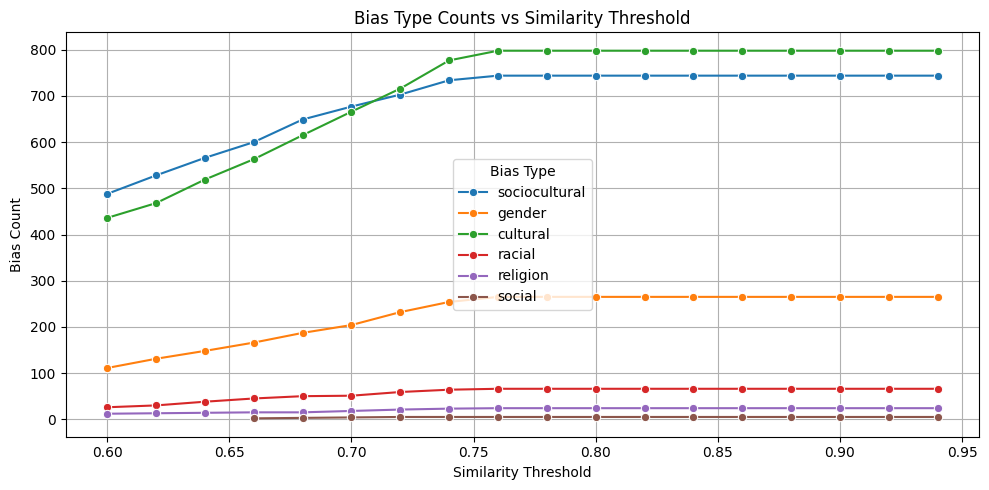

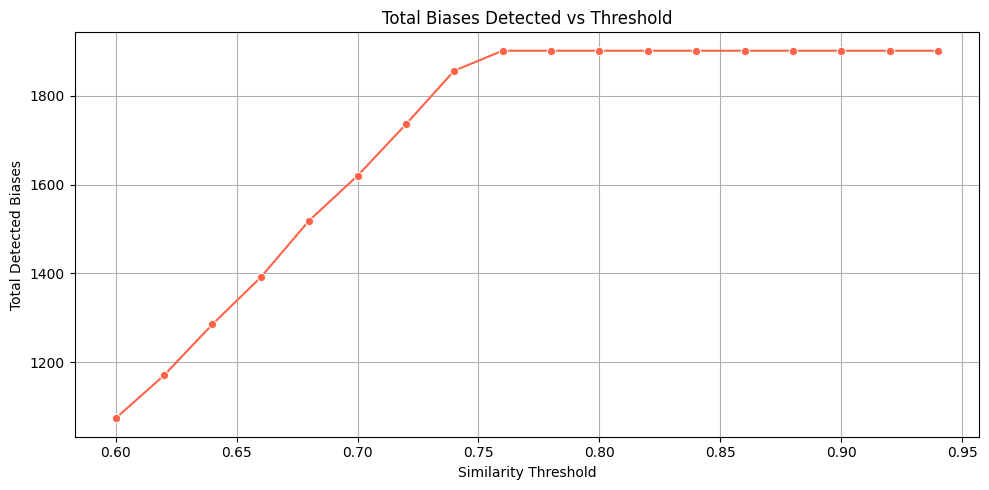

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import ast
import numpy as np
from tqdm import tqdm

# -------------------------
# 📊 Threshold Analysis
# -------------------------

# Load processed CSV
df = pd.read_csv('enhanced_bias_report_all_languages.csv')
df['bias_flags'] = df['bias_flags'].apply(ast.literal_eval)

# Thresholds
thresholds = np.arange(0.60, 0.96, 0.02)

# Evaluation function
def evaluate_threshold(df, threshold):
    count_per_type = {}
    total_flags = 0
    
    for idx, row in df.iterrows():
        if row['similarity'] < threshold:
            bias_flags = row['bias_flags']
            for bias_type in bias_flags:
                count_per_type[bias_type] = count_per_type.get(bias_type, 0) + 1
                total_flags += 1
    return count_per_type, total_flags

# Grid search
results = []

for threshold in tqdm(thresholds, desc="Grid Search on Thresholds"):
    counts, total = evaluate_threshold(df, threshold)
    for bias_type, count in counts.items():
        results.append({
            'threshold': round(threshold, 2),
            'bias_type': bias_type,
            'count': count,
            'total_flags': total
        })

results_df = pd.DataFrame(results)

# 🎨 Visualization: Bias Type Counts by Threshold
plt.figure(figsize=(10, 5))
sns.lineplot(data=results_df, x='threshold', y='count', hue='bias_type', marker='o')
plt.title("Bias Type Counts vs Similarity Threshold")
plt.xlabel("Similarity Threshold")
plt.ylabel("Bias Count")
plt.grid(True)
plt.legend(title='Bias Type')
plt.tight_layout()
plt.savefig("per_bias_optimal_threshold_plot.png", dpi=300)
plt.show()

# 🎨 Visualization: Total Biases Detected by Threshold
total_bias_df = results_df.groupby('threshold')['total_flags'].first().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=total_bias_df, x='threshold', y='total_flags', marker='o', color='tomato')
plt.title("Total Biases Detected vs Threshold")
plt.xlabel("Similarity Threshold")
plt.ylabel("Total Detected Biases")
plt.grid(True)
plt.tight_layout()
plt.savefig("optimal_threshold_plot.png", dpi=300)  # 📥 Save figure
plt.show()

100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 28.01it/s]


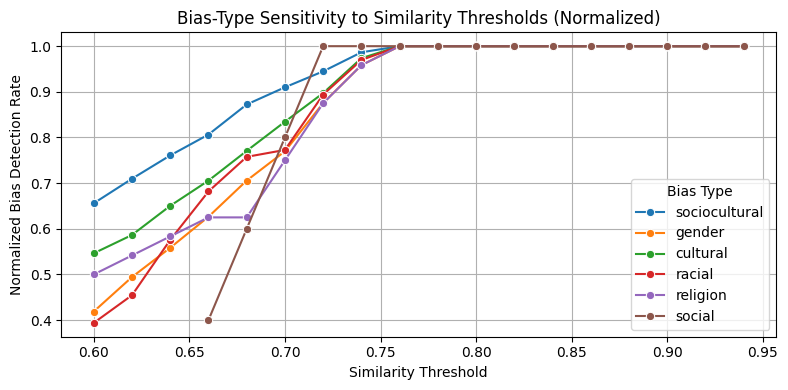

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from tqdm import tqdm

# Load the bias report
df = pd.read_csv("enhanced_bias_report_all_languages.csv")
df['bias_flags'] = df['bias_flags'].apply(ast.literal_eval)

# Set threshold range
thresholds = np.arange(0.60, 0.96, 0.02)

# Function to count biases per threshold
def evaluate_threshold(df, threshold):
    count_per_type = {}
    for idx, row in df.iterrows():
        if row['similarity'] < threshold:
            for bias_type in row['bias_flags']:
                count_per_type[bias_type] = count_per_type.get(bias_type, 0) + 1
    return count_per_type

# Grid search for all thresholds
results = []
for threshold in tqdm(thresholds):
    counts = evaluate_threshold(df, threshold)
    for bias_type, count in counts.items():
        results.append({
            'threshold': round(threshold, 2),
            'bias_type': bias_type,
            'count': count
        })

results_df = pd.DataFrame(results)

# Normalize counts per bias type (to analyze sensitivity)
max_counts = results_df.groupby("bias_type")['count'].max().reset_index()
max_counts.columns = ['bias_type', 'max_count']

results_df = results_df.merge(max_counts, on='bias_type')
results_df['normalized'] = results_df['count'] / results_df['max_count']

# -----------------------------------------------
# 🎨 Plot: Normalized Bias Sensitivity per Type
# -----------------------------------------------
plt.figure(figsize=(8, 4))
sns.lineplot(data=results_df, x='threshold', y='normalized', hue='bias_type', marker='o')
plt.title("Bias-Type Sensitivity to Similarity Thresholds (Normalized)")
plt.xlabel("Similarity Threshold")
plt.ylabel("Normalized Bias Detection Rate")
plt.grid(True)
plt.legend(title="Bias Type")
plt.tight_layout()
plt.savefig("normalized_optimal_threshold_plot.png", dpi=300)
plt.show()


📊 Total Bias Type Counts:
 bias_type
cultural         798
sociocultural    744
gender           265
racial            66
religion          24
social             5
Name: count, dtype: int64


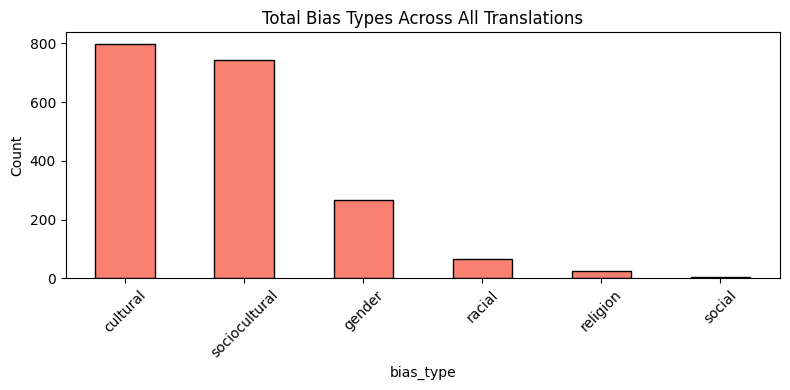

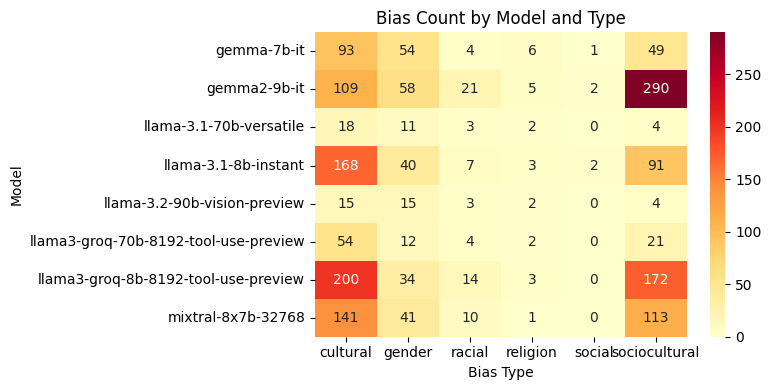

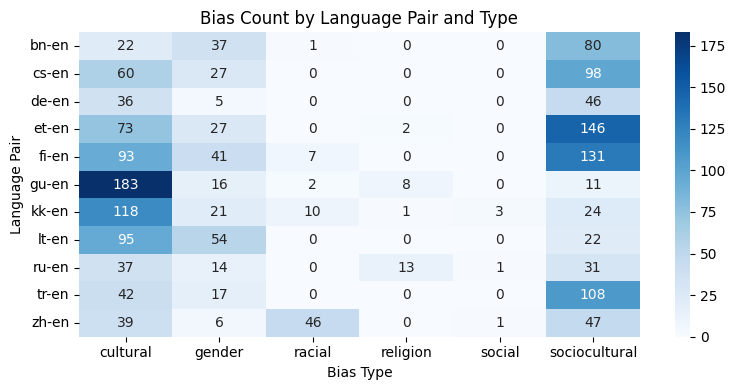

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import ast

# Load the processed bias report
df = pd.read_csv("enhanced_bias_report_all_languages.csv")

# Convert string to list if needed
df['bias_flags'] = df['bias_flags'].apply(ast.literal_eval)

# -------------------------------
# 📦 Unpack bias types properly
# -------------------------------

# No need to extract keys anymore (it’s already a list)
df['bias_type'] = df['bias_flags']

# Now explode it
df_exploded = df.explode('bias_type')

# -------------------------------
# 📊 Total Bias Type Counts
# -------------------------------
total_bias_counts = df_exploded['bias_type'].value_counts()
print("\n📊 Total Bias Type Counts:\n", total_bias_counts)

# -------------------------------
# 🔍 Grouped by Model
# -------------------------------
model_bias = df_exploded.groupby(['model_name', 'bias_type']).size().unstack(fill_value=0)

# -------------------------------
# 🔍 Grouped by Language Pair
# -------------------------------
lang_bias = df_exploded.groupby(['language_pair', 'bias_type']).size().unstack(fill_value=0)

# -------------------------------
# 📈 Visualizations
# -------------------------------

# Basic Bar Plot of Total Bias Types
plt.figure(figsize=(8, 4))
total_bias_counts.plot(kind='bar', color='salmon', edgecolor='black')
plt.title("Total Bias Types Across All Translations")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("total_bias_types.png", dpi=300)  # 📥 Save figure
plt.show()

# Heatmap: Bias by Model
plt.figure(figsize=(8, 4))
sns.heatmap(model_bias, annot=True, fmt="d", cmap="YlOrRd")
plt.title("Bias Count by Model and Type")
plt.ylabel("Model")
plt.xlabel("Bias Type")
plt.tight_layout()
plt.savefig("bias_by_model.png", dpi=300)  # 📥 Save figure
plt.show()

# Heatmap: Bias by Language Pair
plt.figure(figsize=(8, 4))
sns.heatmap(lang_bias, annot=True, fmt="d", cmap="Blues")
plt.title("Bias Count by Language Pair and Type")
plt.ylabel("Language Pair")
plt.xlabel("Bias Type")
plt.tight_layout()
plt.savefig("bias_by_language_pair.png", dpi=300)  # 📥 Save figure
plt.show()

In [5]:
import pandas as pd

# Load the final output CSV
df = pd.read_csv('enhanced_bias_report_all_languages.csv')

# Define a mapping from bias flag keyword to example title
bias_example_titles = {
    'gender': '=== EXAMPLE OF GENDER BIAS ===',
    'racial': '=== EXAMPLE OF RACIAL BIAS ===',
    'religion': '=== EXAMPLE OF RELIGION BIAS ===',
    'social': '=== EXAMPLE OF SOCIAL BIAS ===',
    'cultural': '=== EXAMPLE OF CULTURAL BIAS ==='
}

# To track if we've already printed an example for a bias type
printed_biases = set()

# Helper function to clean and parse the bias_flags
def extract_bias_types(bias_flags_str):
    try:
        bias_list = eval(bias_flags_str)
        # Extract only the bias type (e.g., 'added: temple' -> 'religion' if temple is religion)
        extracted = []
        for bias in bias_list:
            for bias_type in bias_example_titles.keys():
                if bias_type in bias.lower():
                    extracted.append(bias_type)
        return list(set(extracted))
    except:
        return []

# Go through each row and print the first matching example for each bias type
for idx, row in df.iterrows():
    bias_types = extract_bias_types(row['bias_flags'])

    for bias in bias_types:
        if bias not in printed_biases:
            print(bias_example_titles[bias])
            print(f"Similarity    : {row['similarity']:.4f}")
            print(f"Model         : {row['model_name']}")
            print(f"Language Pair : {row['language_pair']}")
            print(f"Source        : {row['Source']}")
            print(f"Reference     : {row['Reference']}")
            print(f"Translation   : {row['Translation']}")
            print(f"Bias Flags    : {row['bias_flags']}")
            print()  # Empty line for spacing
            printed_biases.add(bias)
            break  # Move to the next row after printing one example per bias type

# In case no examples found
for bias in bias_example_titles.keys():
    if bias not in printed_biases:
        print(f"No example found for {bias_example_titles[bias]}")

=== EXAMPLE OF CULTURAL BIAS ===
Similarity    : 0.6172
Model         : llama-3.1-70b-versatile
Language Pair : de-en
Source        : Weidezaunprojekt ist elementar
Reference     : Pasture fence project is fundamental
Translation   : The translation of the German text to English is:

Fence pasture project is elementary
Bias Flags    : ['cultural', 'sociocultural']

=== EXAMPLE OF GENDER BIAS ===
Similarity    : 0.6879
Model         : llama-3.1-70b-versatile
Language Pair : de-en
Source        : Die "Schwarzwaldmilch" ist für ihn der alternativlose Vermarktungsweg für die Milch seiner Kühe, so Schwendemann.
Reference     : Schwendemann says that, for him, there is no alternative to the "Black Forest milk" marketing channel he uses for the milk from his cows.
Translation   : "Schwarzwaldmilch" is for him the only alternative marketing route for the milk of his cows, according to Schwendemann.
Bias Flags    : ['cultural', 'gender']

=== EXAMPLE OF RELIGION BIAS ===
Similarity    : 0.6921


In [6]:
import pandas as pd
import ast

# Load the final output CSV
df = pd.read_csv('enhanced_bias_report_all_languages.csv')

# Define a mapping from bias flag keyword to example title
bias_example_titles = {
    'gender': '=== EXAMPLE OF GENDER BIAS ===',
    'racial': '=== EXAMPLE OF RACIAL BIAS ===',
    'religion': '=== EXAMPLE OF RELIGION BIAS ===',
    'social': '=== EXAMPLE OF SOCIAL BIAS ===',
    'cultural': '=== EXAMPLE OF CULTURAL BIAS ==='
}

# Helper function to clean and parse the bias_flags
def extract_bias_types(bias_flags_str):
    try:
        bias_list = ast.literal_eval(bias_flags_str)
        extracted = []
        for bias in bias_list:
            for bias_type in bias_example_titles.keys():
                if bias_type in bias.lower():
                    extracted.append(bias_type)
        return list(set(extracted))
    except:
        return []

# Create a new column with bias types
df['bias_type_list'] = df['bias_flags'].apply(extract_bias_types)

# Explode to have one bias type per row
df_exploded = df.explode('bias_type_list')

# Dictionary to hold the lowest similarity example for each bias type
examples = {}

# Find the lowest similarity example for each bias type
for bias_type in bias_example_titles.keys():
    filtered = df_exploded[df_exploded['bias_type_list'] == bias_type]
    if not filtered.empty:
        # Get the row with the lowest similarity
        lowest_sim_row = filtered.loc[filtered['similarity'].idxmin()]
        examples[bias_type] = lowest_sim_row

# Print the examples
for bias_type, title in bias_example_titles.items():
    if bias_type in examples:
        row = examples[bias_type]
        print(title)
        print(f"Similarity    : {row['similarity']:.4f}")
        print(f"Model         : {row['model_name']}")
        print(f"Language Pair : {row['language_pair']}")
        print(f"Source        : {row['Source']}")
        print(f"Reference     : {row['Reference']}")
        print(f"Translation   : {row['Translation']}")
        print(f"Bias Flags    : {row['bias_flags']}")
        print()  # Empty line for spacing
    else:
        print(f"No example found for {title}\n")

=== EXAMPLE OF GENDER BIAS ===
Similarity    : 0.0983
Model         : gemma-7b-it
Language Pair : lt-en
Source        : Tu buvai jo priešas.
Reference     : You was against him.
Translation   : The translation of the Lithuanian text "Tu buvai jo priešas." to English is "You were his friend before."
Bias Flags    : ['cultural', 'gender']

=== EXAMPLE OF RACIAL BIAS ===
Similarity    : 0.2171
Model         : gemma-7b-it
Language Pair : kk-en
Source        : Біріншіден, Қытай көрсеткіштерді тым ұлғайтып жіберсе ғана мұндай пікірталасты бастаудың жөні бар.
Reference     : First, the debate is relevant only if China is increasing the degree to which it overestimates its data.
Translation   : Today, the Chinese border guards have escalated tensions by sending troops into the area.
Bias Flags    : ['racial', 'sociocultural']

=== EXAMPLE OF RELIGION BIAS ===
Similarity    : 0.0766
Model         : gemma-7b-it
Language Pair : gu-en
Source        : બનાસ ડેરીના ટેંકર ચાલકોએ કરી હડતાળ, જુઆે વીડિયો